In [4]:
import os
from os import system 
import requests
from glob import glob

import warnings

from math import factorial

import numpy as np

from scipy import integrate
from scipy.special import gamma, gammainc


from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy import stats
from astropy.wcs import WCS
from astropy import utils
from astropy.convolution import convolve_fft
from astropy.stats import sigma_clipped_stats


from dsii_dwarfs.make_galaxies import (SimulateRandomDwarfElliptical, convolve_fft, cosmo, do_find_nearest, find_nearest, 
                                       rebin, observed_cts_per_sec, NoisePicker, modeling)

from dsii_dwarfs.psf_picker import HSCMoffatPSFPicker

ModuleNotFoundError: No module named 'imf'

In [ ]:
pwd

In [4]:
# Matplotlib
# Visualization
import astropy.visualization as vis

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Parameters

In [5]:
# https://hsc-release.mtk.nao.ac.jp username and passowrd
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#
#! Reset to empty string after use! !#
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

username = 'robelgeda'
password = 'kjopuLR3xW8sHyaviBhoKgCDjxYopSnGLUIAUS+n'


# Input Paths
# -----------
# Top level HSC folder path:
hsc_top_path = "/Users/rgeda/project/local/harry/dwarf/data/s16a_deep" 


# Output and Temp Paths
# ---------------------
# Output path:
output_path = "/Users/rgeda/project/local/harry/dwarf/data/outputs"

# Temp folder to store temporary files:
temp_path = "/Users/rgeda/project/local/harry/dwarf/data/temp"

# Dwarf Params
# -------------
npix = 256*2 # Must be even
min_number_dward_per_patch = 3
max_number_dward_per_patch = 5

# Patch padding: sets the margins of where the dwarfs will be placed
# So a patch_padding of 100 pixels will insure all dwarfs will be palced 
# 100 pixels within the HSC patch images.
patch_padding = npix + 2 # Pixels


In [6]:
# User must create paths to avoid mistakes
assert os.path.isdir(hsc_top_path)
assert os.path.isdir(output_path)
assert os.path.isdir(temp_path)

# File Base

Find all HSC patch image files and organize them into patchs

In [7]:
class HSCPatch():
    """
    Holds information about the location of image 
    files for each path. 
    Each patch has a g, i, r, y and z band image.
    Each patch needs to be set by accssing the attribute.
    
    Parameters
    ----------
    name : string
        Name of patch
        
    """
    def __init__(self, name):
        self.name = name 
        self.tract, self.patch = name.split("_")
        
        self.g = None # Path to g band image 
        self.i = None # Path to i band image 
        self.r = None # Path to r band image 
        self.y = None # Path to y band image 
        self.z = None # Path to z band image 
        
    
    def info(self):
        print("name:\t{}".format(name))
        print("g:\t{}".format(self.g))
        print("i:\t{}".format(self.i))        
        print("r:\t{}".format(self.r))        
        print("y:\t{}".format(self.y))        
        print("z:\t{}".format(self.z))  
    
    @property
    def bands(self):
        """"
        Make sure to match the following order: 
        'g','r','i','z','y'
        """
        return {
            "g": self.g,
            "r": self.r,
            "i": self.i,
            "z": self.z,
            "y": self.y,
        }

In [8]:
patch_dict = {}

In [9]:
fb = glob(hsc_top_path+"/**/calexp-HSC*.gz", recursive=True) # Filebase

for f in fb:
    
    fbase = os.path.basename(f)
    band, *name = fbase.split(".")[0].split("-")[2:]
    name = "_".join(name)
    if name not in patch_dict:
        patch_dict[name] = HSCPatch(name)
    setattr(patch_dict[name], band.lower(), f)
    
for name in patch_dict:
    for band in ['g', 'i', 'r', 'y', 'z']:
        assert getattr(patch_dict[name], band) is not None, "error, patch {} is missing {} band".format(name, band)
    print("✓ {}".format(name))
    
print("\nNumber of Patches: ", len(patch_dict))

✓ 9463_0,7
✓ 9463_0,8
✓ 9464_7,7
✓ 9464_7,8
✓ 9464_8,7
✓ 9464_8,8
✓ 9706_0,0
✓ 9707_7,0
✓ 9707_8,0

Number of Patches:  9


# Generate Dwarfs 

In [9]:
class DwarfSersic2D(modeling.models.Sersic2D):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.normalization = self.compute_normalization()
        
    def compute_normalization(self):
        x = self.x_0.value 
        y = self.y_0.value
        delta = self.r_eff.value * 8
        return integrate.dblquad(self, x-delta, x+delta, y-delta, y+delta)[0]
        
    def compute_npix(self, noise_level, total_flux, max_npix=4000, oversample=5):
        model_1d = models.Sersic1D(self.amplitude, self.r_eff, self.n)
                
        x = np.arange(0, max_npix//2, oversample)
        x = x
        
        values = total_flux*(model_1d(x)/self.normalization)
        
        if noise_level > values[0]:
            raise Exception("Noise too large, max noise = {}".format(values[0]))
            
        if noise_level < values[-1]:
            raise Exception("Noise too small, min noise = {}".format(values[-1]))
        
        argmin = abs(values - noise_level).argmin()
        
        return int(x[argmin] * 2) 


In [15]:
class PSFFitSimulateDwarfElliptical(SimulateRandomDwarfElliptical):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.flux_fade_cutoff = 0.074/self.oversampling**2
        self.Nospix = None
            
        
    def simulate_HSCimage(self):
        """ Pick a PSF for each band, convolve, downsample, and add noise """
        # Pick PSF section is done externally by main loop
        
        # Convolve with them
        convolved_image = {}
        for b in self.bands:
            convolved_image[b] = convolve_fft(self.galaxy_image[b],self.psf[b])
        # Rebin to the HSC pixel scale
        self.noiseless_image = {}
        nbinnedpix = int(self.Nospix/self.oversampling)
        
        print(nbinnedpix, convolved_image[b].shape)
        for b in self.bands:
            self.noiseless_image[b] = rebin(convolved_image[b],nbinnedpix,nbinnedpix)
        # Pick noise and add it to the rebinned image
        self.HSCimage = {}
        npick = NoisePicker(sigma_range=(0.015,0.04))
        self.noise_sigma = {}
        for b in self.bands:
            self.HSCimage[b] = self.noiseless_image[b] + \
                 npick.pick_noise(size=self.noiseless_image[b].shape)
            self.noise_sigma[b] = npick.sigma

    def create_mass_model(self):
        print("create_mass_model")
        self.model = DwarfSersic2D(
            amplitude=1,
            r_eff=self.re_pixels,
            n=self.sersic_index,
            x_0=0, y_0=0,
            ellip=self.ellipticity,theta=self.position_angle)
        
        """
        total_flux = self.mass * observed_cts_per_sec(self.smooth_flux["z"],
                                                      self.distance,self.zpt["z"])
        N  = self.model.compute_npix(self.flux_fade_cutoff, total_flux)
        """
        
        N = self.re_pixels * 2
        
        # Round to the nearest even number divisable by self.oversampling
        N = int( self.oversampling * round( N / self.oversampling ))
        
        if int(N/self.oversampling) % 2 == 1:
            N += int(self.oversampling)

        self.Nospix = N 
        

        x, y = np.meshgrid(np.arange(-N, +N), 
                           np.arange(-N, +N))
        
        self.normalization = self.model.normalization
        self.model_image = self.model(x,y)/self.normalization
        self.mass_model = self.model_image*self.mass
        
        self.x = x + N 
        self.y = y + N
        
        
    def save_noiseless_fits(self,directory):
        filename_template = f"d{self.distance:.2f}_"
        filename_template += f"m{self.logmass:.2f}_re{self.re_kpc:.2f}_"
        filename_template += f"feh{self.feh:.1f}_age{self.age:.1f}"
        # Write out the noiseless image
        noiseless_file = directory+"/"+filename_template+"_noiseless.fits"
        noiseless_cube = np.stack([self.noiseless_image[b] for b in self.bands],axis=0)
        hdu_noiseless = fits.PrimaryHDU(noiseless_cube)
        self.write_header_keywords(hdu_noiseless)
        hdu_noiseless.writeto(noiseless_file, overwrite=True)
        return noiseless_file
    
    
    

In [16]:
def find_center(array):
    return (np.array(array.shape)-1)/2

class FitPSF():
    def __init__(self,band,filename):
    #Read PSF file
        self.filename = filename 
        psf_hdu = fits.open(self.filename)
        psf_data = psf_hdu[0].data
    
        # Generate grid
        self.x, self.y = np.mgrid[:psf_data.shape[0], :psf_data.shape[1]]
        self.z = psf_data
    
    def dofit(self):
        # Fit the data using astropy.modeling
        center_x, center_y = find_center(self.z)
        p_init = models.Moffat2D(x_0=center_x, y_0=center_y)
        fit_p = fitting.LevMarLSQFitter()
        with warnings.catch_warnings():
            # Ignore model linearity warning from the fitter
            warnings.simplefilter('ignore')
            self.model = fit_p(p_init, self.x, self.y, self.z)
        print("Mean Residual:", (self.z - self.model(self.x, self.y)).mean())
        self.params = Table(data=[self.model.param_names, self.model.parameters], names=["param_names", "param_vals"])
        self.gamma = self.model.parameters[3]
        self.alpha = self.model.parameters[4]
        self.fwhm = self.model.fwhm
    
    def plot_results(self):
    # Plot the data with the best-fit model
        vmin, vmax = np.percentile(self.z,1.), np.percentile(self.z,99.)
        print(vmin,vmax)
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(self.z, origin='lower', interpolation='nearest',vmin=vmin,vmax=vmax)
        plt.title("Data")
        plt.subplot(1, 3, 2)
        plt.imshow(self.model(self.x, self.y), origin='lower', interpolation='nearest',vmin=vmin,vmax=vmax)
        plt.title("Model")
        plt.subplot(1, 3, 3)
        plt.imshow(100.*(self.z - self.model(self.x, self.y))/self.z, origin='lower', interpolation='nearest',
                   vmin=0,vmax=100.)
        plt.title("Residual in percent")

In [17]:
def pick_dwarf_position(num_dwarfs, naxis1, naxis2, patch):
    """Return a list of (x, y) pixel coords of dwarf centers"""
    global patch_padding, npix
    
    assert naxis1-patch_padding > 0
    assert naxis2-patch_padding > 0
    
    galaxy_pos = []
    for i in range(num_dwarfs):
        unique = False
        while not unique:
            x = np.random.randint(patch_padding, naxis1-patch_padding)
            y = np.random.randint(patch_padding, naxis2-patch_padding)
            
            unique = True 
            for xi, yi in galaxy_pos:
                dist = abs(np.linalg.norm(np.array([x, y])-np.array([xi, yi])))
                if dist < npix:
                    unique = False
                    break
                
        galaxy_pos.append((x, y))        
    
    return galaxy_pos

In [18]:
def get_psf(ra, dec, band, patch):
    return "/Users/rgeda/project/local/harry/dwarf/data/temp/psf_9463_0,7_{}.fits".format(band)
    global username, password, temp_path
    url = 'https://hsc-release.mtk.nao.ac.jp/psf/s16a/cgi/getpsf?ra={:0.2f}&dec={:0.2f}&filter={}&rerun=s16a_deep&tract={}&patch={}&type=coadd'.format(ra, dec, band, patch.tract, patch.patch)

    r = requests.get(url, auth=(username,password))
    
    filename = "psf_{}_{}.fits".format(patch.name, band)
    filename = os.path.join(temp_path, filename)
    if r.status_code == 200:
        with open(filename, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
    else:
        raise Exception("PSF NOT FOUND: Check link in get_psf(...)n\Check if correct data version pdr2 or s16a.\nURL: {}".format(url))
    
    # psf = fits.getdata(filename)
    return filename

In [19]:
def get_new_sim():
    print("SimulateRandomDwarfElliptical")
    sim = PSFFitSimulateDwarfElliptical(dmax=15.,MF_min=1.e5,MF_max=1.e9, npix=npix, oversampling=5)

    print("sim.pick_galaxy")
    sim.pick_galaxy()
    
    return sim

In [20]:

# For each HSC path
for count, name in enumerate(patch_dict):
    catalog = []
       
    # Set basic params for this patch
    patch = patch_dict[name]
    num_dwarfs = np.random.randint(min_number_dward_per_patch, max_number_dward_per_patch+1)
    
    print("="*50)
    print("{} of {}: {}".format(count+1, len(patch_dict), name))
    print("Number of Dwarfs:", num_dwarfs)
        
    header = fits.getheader(patch.g, ext=1)
    naxis1 = header["NAXIS1"]
    naxis2 = header["NAXIS2"]
    w = WCS(header)
    
    # Generate positions
    galaxy_pos = pick_dwarf_position(num_dwarfs, naxis1, naxis2, patch)
    
    galaxy_radec = w.all_pix2world(galaxy_pos,0)

    galaxy_delta_pos = []
    
    # Create output image
    output_patch_data = np.zeros( (5, naxis2, naxis1) )
    for i, (band, patch_path) in enumerate(patch.bands.items()):
        output_patch_data[i] = fits.getdata(patch_path)

    for dwarf_index, pos in enumerate(galaxy_radec):
        print("-"*50)
        ra, dec = np.round(pos[0], 5), np.round(pos[1], 5)
        dwarf_name = "{}_{}_{}".format(name, ra, dec)
        print(dwarf_name)
        
        print("get_new_sim")
        sim = get_new_sim()
            
        print("mass: ",np.log10(sim.mass))
        print("distance: ",sim.distance)
        print("re_kpc, arcsec, pix: ",sim.re_kpc, sim.re_arcsec, sim.re_pixels)
        print("[Fe/H]: ",sim.feh)
        print("age: ",sim.age)
        print("ellip: ",sim.ellipticity)
        print("pa: ",sim.position_angle)
        print("")

        print("sim.renormalize_isochrone")
        sim.renormalize_isochrone()

        print("sim.compute_smooth_flux")
        sim.compute_smooth_flux()

        print("sim.create_smooth_portion")
        sim.create_smooth_portion()
        
        print("sim.create_stochastic_portion()")
#         sim.create_stochastic_portion()
        
        print("sim.sum_components")
#         sim.sum_components()

        print("PSF")
        results = Table([np.array([]),np.array([]),np.array([]),np.array([])],names=['band','gamma','alpha','fwhm'],
                        dtype=['S2','f4','f4','f4'])
        for band in patch.bands:
            psf_path = get_psf(ra, dec, band, patch)
            psf_fit = FitPSF(band, psf_path)
            psf_fit.dofit()
            results.add_row([band, psf_fit.gamma, psf_fit.alpha, psf_fit.fwhm*0.17])

        sim.psf_gamma = {}
        sim.psf_alpha = {}
        sim.psf = {}
        for line in results:
            b = line['band'].lower()
            pf = HSCMoffatPSFPicker(oversampling=sim.oversampling, gamma0=line['gamma'],alpha0=line['alpha'])
            sim.psf_gamma[b],sim.psf_alpha[b],sim.psf[b] = pf.get_oversampled_psf()
        
        print("sim.simulate_HSCimage")
        sim.simulate_HSCimage()

        print("save")
        noiseless_file = sim.save_noiseless_fits(output_path)
        
        dwarf_data = fits.getdata(noiseless_file)
        
        xcenter, ycenter = galaxy_pos[dwarf_index]
        dx, dy = dwarf_data[0].shape
#         assert dx == npix and dy == npix
        galaxy_delta_pos.append(dx)
        
        for i, (band, patch_path) in enumerate(patch.bands.items()):
            output_patch_data[i, ycenter-dy//2:ycenter+dy//2, xcenter-dx//2:xcenter+dx//2] += dwarf_data[i]      

        print("\n")

        
    final_path_output_path = os.path.join(output_path, "hsc_dwarf_sim_{}.fits".format(patch.name))
    
    fits.HDUList([fits.PrimaryHDU(data=output_patch_data, header=header)]).writeto(final_path_output_path, overwrite=True)
    

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(output_patch_data[0]-fits.getdata(patch.g), vmax=0.39, vmin=0, origin='lower',)

    # Create a Rectangle patch
    for i, (x,y) in enumerate(galaxy_pos):
        dx = galaxy_delta_pos[i]
        rect = patches.Rectangle((x-dx//2, y-dx//2),dx,dx,linewidth=0.1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    # Create a Rectangle patch
    for i, (x,y) in enumerate(galaxy_pos):
        dx = 256
        rect = patches.Rectangle((x-dx//2, y-dx//2),dx,dx,linewidth=0.5,linestyle="--",edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    image_output_path = os.path.join(output_path, "hsc_dwarf_sim_{}_dwarfs_only.png".format(patch.name))
    fig.savefig(image_output_path, dpi=1000)
    
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(output_patch_data[0], vmax=0.39, vmin=0, origin='lower',)

    # Create a Rectangle patch
    for i, (x,y) in enumerate(galaxy_pos):
        dx = galaxy_delta_pos[i]
        rect = patches.Rectangle((x-dx//2, y-dx//2),dx,dx,linewidth=0.1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    # Create a Rectangle patch
    for i, (x,y) in enumerate(galaxy_pos):
        dx = 256
        rect = patches.Rectangle((x-dx//2, y-dx//2),dx,dx,linewidth=0.5,linestyle="--",edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    image_output_path = os.path.join(output_path, "hsc_dwarf_sim_{}.png".format(patch.name))
    fig.savefig(image_output_path, dpi=1000)
    
    # Exact 
    for i, pos in enumerate(galaxy_pos):
        xcenter, ycenter = pos
        dx = dy = galaxy_delta_pos[i]
        tl = (xcenter+dx//2, ycenter+dy//2)
        tr = (xcenter-dx//2, ycenter+dy//2)
        br = (xcenter-dx//2, ycenter-dy//2)
        bl = (xcenter+dx//2, ycenter-dy//2)
        catalog.append([final_path_output_path, *tl, *tr, *br, *bl, ycenter*naxis2+(naxis2-xcenter)]) #  Last value used for sorting
    
    table_output_path = os.path.join(output_path, "hsc_dwarf_sim_{}_exact.csv".format(patch.name))
    catalog_table = Table(np.array(catalog))
    catalog_table.sort(catalog_table.colnames[-1], reverse=True)
    catalog_table.remove_column(catalog_table.colnames[-1])
    catalog_table.write(table_output_path, format="ascii.csv", overwrite=True)
    
    
    # 256
    for i, pos in enumerate(galaxy_pos):
        xcenter, ycenter = pos
        dx = dy = 256
        tl = (xcenter+dx//2, ycenter+dy//2)
        tr = (xcenter-dx//2, ycenter+dy//2)
        br = (xcenter-dx//2, ycenter-dy//2)
        bl = (xcenter+dx//2, ycenter-dy//2)
        catalog.append([final_path_output_path, *tl, *tr, *br, *bl, ycenter*naxis2+(naxis2-xcenter)]) #  Last value used for sorting
    
    table_output_path = os.path.join(output_path, "hsc_dwarf_sim_{}_256.csv".format(patch.name))
    catalog_table = Table(np.array(catalog))
    catalog_table.sort(catalog_table.colnames[-1], reverse=True)
    catalog_table.remove_column(catalog_table.colnames[-1])
    catalog_table.write(table_output_path, format="ascii.csv", overwrite=True)
    
    


    # print(self.position_angle, self.redshift, self.re_arcsec , self.re_pixels)

1 of 9: 9463_0,7
Number of Dwarfs: 5
--------------------------------------------------
9463_0,7_351.90456_-0.25472
get_new_sim
SimulateRandomDwarfElliptical
sim.pick_galaxy


/Users/rgeda/project/local/harry/dwarf/dsii_dwarfs/dsii_dwarfs/axial_ratio_picker.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cdf_samples = np.array([integrate.quad(self._pdf,0,q)[0] for q in qsamples])


create_mass_model


NameError: name 'DwarfSersic2D' is not defined

In [ ]:
sim.re_pixels, sim.Nospix, sim.Nospix/sim.oversampling

1280

In [ ]:
plt.imshow(sim.galaxy_image['z'])

In [ ]:
plt.imshow(dwarf_data[0])

In [11]:
cd /Users/rgeda/project/local/harry/dwarf/data/outputs

/Users/rgeda/project/local/harry/dwarf/data/outputs


In [14]:
# Zip all files
for count, name in enumerate(patch_dict):
    print(count, len(patch_dict), name)
    patch = patch_dict[name]
    tar_path = "hsc_dwarf_sim_{}".format(patch.name)#os.path.join(output_path, "hsc_dwarf_sim_{}".format(patch.name))
    print(os.system("tar -cvzf {}.tar.gz {}*".format(tar_path, tar_path, output_path)))

0 9 9463_0,7
0
1 9 9463_0,8
0
2 9 9464_7,7
0
3 9 9464_7,8
0
4 9 9464_8,7
0
5 9 9464_8,8
0
6 9 9706_0,0
0
7 9 9707_7,0
256
8 9 9707_8,0
256


# Tests 

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(output_patch_data[0]-fits.getdata(patch.g), vmax=0.39, vmin=0, origin='lower',)

# Create a Rectangle patch
for x,y in galaxy_pos:
    rect = patches.Rectangle((x-dx//2, y-dy//2),npix,npix,linewidth=1,edgecolor='r',facecolor='none')


    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()
fig.savefig("./stamps_robel/targ_subt.png",dpi=1000)


In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(output_patch_data[0], vmax=0.39, vmin=0, origin='lower')

# Create a Rectangle patch
for x,y in galaxy_pos:
    rect = patches.Rectangle((x-dx//2, y-dy//2),npix,npix,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()
fig.savefig("./stamps_robel/targ.png",dpi=1000)

In [ ]:
psf = get_psf(galaxy_radec[0][0], galaxy_radec[0][1], "g", patch)
plt.imshow(psf.data)

In [ ]:

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(data, vmax=0.39, vmin=0, origin='lower')

# Create a Rectangle patch
for x,y in galaxy_pos:
    rect = patches.Rectangle((x-256/2,y-256/2),256,256,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()
fig.savefig("./stamps_robel/targ.png",dpi=1000)

In [ ]:

tar_path = os.path.join(output_path, "hsc_dwarf_sim_{}".format(patch.name))
os.system("tar -cvzf {}.tar.gz {}*".format(tar_path, tar_path))

In [ ]:

def observed_cts_per_sec(isochrone_flux,lumdist,zpt=27.0):
    zptflux = 10.**(zpt/2.5)
    distratio = lumdist *1.e6/10.  # lumdist is in Mpc, isochrone is computed for 10 parsecs
    return isochrone_flux*zptflux/distratio**2

In [ ]:
from astropy.stats import sigma_clipped_stats

In [66]:
p = patch_dict['9463_0,7']

In [67]:
z_data = fits.getdata(p.z)

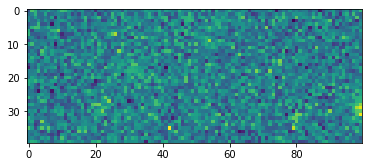

In [68]:
plt.imshow(z_data[10:50, 0:100])

In [71]:
std = sigma_clipped_stats(z_data[10:50, 0:50])

In [72]:
std

(0.012410842, 0.009950412, 0.074147396)

In [73]:
z_data[10:50, 0:100].min()

-0.23751263

In [ ]:
cutoff_value = std/2 /25
cutoff_value

In [31]:
sim.smooth_flux['z'], sim.distance, sim.zpt['z']

(0.005599524557217157, 8.605929668320766, 27.0)

In [32]:
observed_cts_per_sec(sim.smooth_flux['z'],sim.distance,sim.zpt[b])

0.00047704084829118895

In [ ]:
from dsii_dwarfs.make_galaxies import __file__ as fkss

In [ ]:
fkss

In [27]:
sim.model.__call__(np.array([1.1]), np.array([2,3]))

ValueError: cannot reshape array of size 2 into shape (1,)

In [34]:
integrate.quad(salpeter, a=0.01, b=100.)

NameError: name 'salpeter' is not defined

128.3221574589809


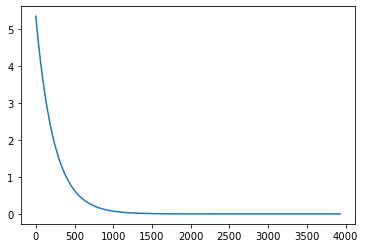

In [50]:
x = np.arange(0, sim.model1D.r_eff.value*10,10)
y = sim.model1D(x)
plt.plot(x,y)
print(sum(y))

In [99]:
print("SimulateRandomDwarfElliptical")
sim = PSFFitSimulateDwarfElliptical(dmax=15.,MF_min=1.e5,MF_max=1.e9, npix=npix)

print("sim.pick_galaxy")
sim.pick_galaxy()


SimulateRandomDwarfElliptical
sim.pick_galaxy


/Users/rgeda/project/local/harry/dwarf/dsii_dwarfs/dsii_dwarfs/axial_ratio_picker.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  cdf_samples = np.array([integrate.quad(self._pdf,0,q)[0] for q in qsamples])


In [155]:
 sim.model1D = modeling.models.Sersic1D(
            amplitude=1,
            r_eff=sim.re_pixels,
            n=sim.sersic_index
        )

In [156]:
integrate.quad(sim.model1D, a=0., b=sim.model1D.r_eff.value*10)

(1586.5127751655573, 6.67049666429121e-06)

In [157]:
integrate.quad(sim.model1D, a=0., b=sim.model1D.r_eff.value*5)

(1586.1531410084626, 1.760983737729108e-11)

In [154]:
integrate.quad(sim.model1D, a=0., b=sim.model1D.r_eff.value*4)

AttributeError: 'PSFFitSimulateDwarfElliptical' object has no attribute 'model1D'

In [153]:
sim.mass*observed_cts_per_sec(sim.smooth_flux['z'],sim.distance,sim.zpt['z'])

46605.58873773231

In [191]:
pixel_array = np.arange(0, 5000, 1)
pixel_values = sim.mass*observed_cts_per_sec(sim.smooth_flux['z'],sim.distance,sim.zpt['z'])/integrate.quad(sim.model1D, a=0., b=sim.model1D.r_eff.value*5)[0] * sim.model1D(pixel_array)

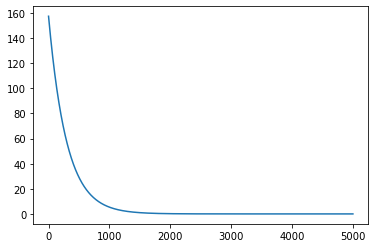

In [192]:
plt.plot(pixel_array, pixel_values)

In [198]:

sim.Nospix, sim.Nospix//2

(2560.0, 1280.0)

In [199]:
sim.galaxy_image['z'][0][1280]

0.000602594561526704

In [197]:
abs(pixel_values - 0.000602594561526704).argmin()

3694

In [177]:
dwarf_data[-2,0,0]

0.00021243275988452642

In [176]:
patch.bands

{'g': '/Users/rgeda/project/local/harry/dwarf/data/s16a_deep/deepCoadd/HSC-G/9463/0,7/calexp-HSC-G-9463-0,7.fits.gz',
 'r': '/Users/rgeda/project/local/harry/dwarf/data/s16a_deep/deepCoadd/HSC-R/9463/0,7/calexp-HSC-R-9463-0,7.fits.gz',
 'i': '/Users/rgeda/project/local/harry/dwarf/data/s16a_deep/deepCoadd/HSC-I/9463/0,7/calexp-HSC-I-9463-0,7.fits.gz',
 'z': '/Users/rgeda/project/local/harry/dwarf/data/s16a_deep/deepCoadd/HSC-Z/9463/0,7/calexp-HSC-Z-9463-0,7.fits.gz',
 'y': '/Users/rgeda/project/local/harry/dwarf/data/s16a_deep/deepCoadd/HSC-Y/9463/0,7/calexp-HSC-Y-9463-0,7.fits.gz'}

In [114]:
sim.flux_fade_cutoff

0.0018384847044944762

In [108]:
pixel_values

array([2.70803623e-06, 2.67980915e-06, 2.65187629e-06, ...,
       4.93491627e-29, 4.88347741e-29, 4.83257472e-29])

In [109]:
sim.model1D(pixel_array)

array([5.35669398e+00, 5.30085874e+00, 5.24560550e+00, ...,
       9.76162577e-23, 9.65987594e-23, 9.55918669e-23])

In [126]:
sim.ttt

0.00025813198700228935

In [127]:
sim.sss

510.6039732269872

In [134]:
pixel_values = sim.ttt/sim.sss*  sim.model1D(pixel_array)

In [135]:
pixel_values

array([2.70803623e-06, 2.70775250e-06, 2.70746879e-06, 2.70718511e-06,
       2.70690146e-06, 2.70661784e-06, 2.70633426e-06, 2.70605070e-06,
       2.70576717e-06, 2.70548367e-06, 2.70520020e-06, 2.70491676e-06,
       2.70463335e-06, 2.70434997e-06, 2.70406661e-06, 2.70378329e-06,
       2.70350000e-06, 2.70321674e-06, 2.70293351e-06, 2.70265030e-06,
       2.70236713e-06, 2.70208399e-06, 2.70180087e-06, 2.70151779e-06,
       2.70123474e-06, 2.70095171e-06, 2.70066872e-06, 2.70038575e-06,
       2.70010281e-06, 2.69981991e-06, 2.69953703e-06, 2.69925418e-06,
       2.69897137e-06, 2.69868858e-06, 2.69840582e-06, 2.69812309e-06,
       2.69784040e-06, 2.69755773e-06, 2.69727509e-06, 2.69699248e-06,
       2.69670990e-06, 2.69642735e-06, 2.69614482e-06, 2.69586233e-06,
       2.69557987e-06, 2.69529744e-06, 2.69501504e-06, 2.69473266e-06,
       2.69445032e-06, 2.69416801e-06, 2.69388572e-06, 2.69360347e-06,
       2.69332124e-06, 2.69303905e-06, 2.69275688e-06, 2.69247474e-06,
      

In [122]:
observed_cts_per_sec(sim.sss, sim.distance, sim.zpt['z'])

20.125673867169507

In [125]:
sim.smooth_flux['z']

0.006549008945004975

In [150]:
dwarf_data.max()

1.2482181348745214

In [152]:
sim.observed_smooth_flux

{'g': 15303.650740040248,
 'r': 19007.98917743851,
 'i': 20030.41591958239,
 'z': 17475.322374173553,
 'y': 19483.6949730106}

In [94]:
model = DwarfSersic2D(
            amplitude=1,
            r_eff=sim.re_pixels,
            n=1,
            x_0=sim.Nospix//2,y_0=sim.Nospix//2,
            ellip=0.5,
            theta=0)

AttributeError: 'PSFFitSimulateDwarfElliptical' object has no attribute 're_pixels'